In [1]:
import oda_api.token 
import logging
import numpy as np
from oda_api.api import DispatcherAPI
from oda_api.plot_tools import OdaImage, OdaLightCurve, OdaSpectrum
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from matplotlib.patches import Circle
from astropy.time import Time

In [26]:
# token = ''
# token = getpass.getpass('Insert the token')
token = oda_api.token.discover_token() # get token stored locally

failed to find token with current method: TokenLocation.ODA_ENV_VAR: 'ODA_TOKEN'
failed to find token with current method: TokenLocation.ODA_ENV_VAR: 'ODA_TOKEN'
searching for token in TokenLocation.FILE_CUR_DIR
searching for token in TokenLocation.FILE_CUR_DIR
found token in TokenLocation.FILE_CUR_DIR your token payload: {
    "email": "hucklethums@icloud.com",
    "exp": 1742905994,
    "name": "interstellxr",
    "roles": "authenticated user, public-pool-hpc",
    "sub": "hucklethums@icloud.com"
}
found token in TokenLocation.FILE_CUR_DIR your token payload: {
    "email": "hucklethums@icloud.com",
    "exp": 1742905994,
    "name": "interstellxr",
    "roles": "authenticated user, public-pool-hpc",
    "sub": "hucklethums@icloud.com"
}
token expires in 336.0 h
token expires in 336.0 h
discovered token method TokenLocation.FILE_CUR_DIR
discovered token method TokenLocation.FILE_CUR_DIR


In [64]:
logging.getLogger().setLevel(logging.INFO) # WARNING, INFO or DEBUG
logging.getLogger('oda_api').addHandler(logging.StreamHandler())

Import the ScWs from the saved file.

In [28]:
scw_ids = []
scw_versions = []
scw_start_times = []
scw_end_times = []
jupiter_ra = []
jupiter_dec = []

with open("../data/2004-01-01_2024-01-01.txt", "r") as f:
    next(f)
    for line in f:
        parts = line.strip().split(", ")
        scw_ids.append(parts[0])
        scw_versions.append(parts[1])
        scw_start_times.append(float(parts[2]))  
        scw_end_times.append(float(parts[3]))  
        jupiter_ra.append(float(parts[4]))  
        jupiter_dec.append(float(parts[5]))  

unique_sorted_data = {}
for sid, ver, start, end, ra, dec in sorted(zip(scw_ids, scw_versions, scw_start_times, scw_end_times, jupiter_ra, jupiter_dec), key=lambda x: x[0]):
    if sid not in unique_sorted_data:  
        unique_sorted_data[sid] = (sid, ver, start, end, ra, dec)

scw_ids, scw_versions, scw_start_times, scw_end_times, jupiter_ra, jupiter_dec = map(list, zip(*unique_sorted_data.values()))

Add IDs and versions together to make correctly formatted ScWs, and compute durations of the ScW observations.

In [29]:
scw_list = [id + "." + ver for id, ver in zip(scw_ids, scw_versions)]
scw_durations = [(end - start)*24*60 for start, end in zip(scw_start_times, scw_end_times)]
print(scw_list)
print(scw_durations)
print([Time(start, format='mjd').isot for start in scw_start_times])
print("Max duration in minutes:", np.max(scw_durations), "at position", np.argmax(scw_durations))

['026601100010.001', '026601110010.001', '026700000210.001', '026700000230.001', '043200640010.001', '043200650010.001', '091700010010.001', '091700020010.001', '106300180010.001', '106300190010.001', '112600220010.001', '112600230010.001', '124200010010.001', '124200020010.001', '168600570010.001', '168600580010.001', '169500010010.001', '169500020010.001', '230200070010.001', '230200080010.001', '230200090010.001', '230200160010.001', '230200170010.001', '230200180010.001', '230200470010.001', '230200480010.001', '230200490010.001', '230200550010.001', '230200560010.001', '230200570010.001', '230200570020.001', '236600410010.001', '236600420010.001', '236600440010.001', '236600450010.001', '236600460010.001', '236600470010.001', '236600480010.001', '236600490010.001', '236600500010.001', '236600510010.001', '236600520010.001', '236600530010.001', '236600540010.001', '236600550010.001', '236600560010.001', '236600570010.001', '236600580010.001', '236600590010.001', '236600600010.001',

We hardcore a catalog for Jupiter.

In [43]:
list_position = 3

# Jupiter
ra_deg = jupiter_ra[list_position]
dec_deg = jupiter_dec[list_position]

if Time(scw_start_times[list_position], format='mjd').isot > '2016':
    osa_version = "OSA11.2"
else:
    osa_version = "OSA10.2"

api_cat={
    "cat_frame": "fk5",
    "cat_coord_units": "deg",
    "cat_column_list": [
        [0],
        ["Jupiter"],
        [125.4826889038086],
        [ra_deg],
        [dec_deg],
        [-32768],
        [2],
        [0],
        [0.0002800000074785203]],
    "cat_column_names": [
        "meta_ID",
        "src_names",
        "significance",
        "ra",
        "dec",
        "NEW_SOURCE",
        "ISGRI_FLAG",
        "FLAG",
        "ERR_RAD"
    ],
    "cat_column_descr":
        [
            ["meta_ID", "<i8"],
            ["src_names", "<U11"],
            ["significance", "<f8"],
            ["ra", "<f8"],
            ["dec", "<f8"],
            ["NEW_SOURCE", "<i8"],
            ["ISGRI_FLAG", "<i8"],
            ["FLAG", "<i8"],
            ["ERR_RAD", "<f8"]
        ],
    "cat_lat_name": "dec",
    "cat_lon_name": "ra"
}


Query the ODA API.

In [44]:
import json

disp = DispatcherAPI(url="https://www.astro.unige.ch/mmoda/dispatch-data", instrument="mock")

par_dict = {
"RA": ra_deg,
"DEC": dec_deg,
"E1_keV": "15",
"E2_keV": "30", 
"T_format": "mjd",
'T1': scw_start_times[list_position],
'T2': scw_end_times[list_position],
"time_bin": "60", 
"instrument": "isgri",
"osa_version": osa_version,
"product": "isgri_lc",
"product_type": "Real",
"scw_list": [scw_list[list_position]],
'token': token,
'selected_catalog': json.dumps(api_cat)
}

data_collection = disp.get_product(**par_dict)
data_collection.show()

failed to find token with current method: TokenLocation.ODA_ENV_VAR: 'ODA_TOKEN'
failed to find token with current method: TokenLocation.ODA_ENV_VAR: 'ODA_TOKEN'
failed to find token with current method: TokenLocation.ODA_ENV_VAR: 'ODA_TOKEN'
searching for token in TokenLocation.FILE_CUR_DIR
searching for token in TokenLocation.FILE_CUR_DIR
searching for token in TokenLocation.FILE_CUR_DIR
found token in TokenLocation.FILE_CUR_DIR your token payload: {
    "email": "hucklethums@icloud.com",
    "exp": 1742905994,
    "name": "interstellxr",
    "roles": "authenticated user, public-pool-hpc",
    "sub": "hucklethums@icloud.com"
}
found token in TokenLocation.FILE_CUR_DIR your token payload: {
    "email": "hucklethums@icloud.com",
    "exp": 1742905994,
    "name": "interstellxr",
    "roles": "authenticated user, public-pool-hpc",
    "sub": "hucklethums@icloud.com"
}
found token in TokenLocation.FILE_CUR_DIR your token payload: {
    "email": "hucklethums@icloud.com",
    "exp": 17429

ID=0 prod_name=isgri_lc_0_Jupiter  meta_data: {'src_name': 'Jupiter', 'time_bin': 0.000694401273995027, 'time': 'TIME', 'rate': 'RATE', 'rate_err': 'ERROR'}



LIGHT CURVE

In [63]:
data_collection.isgri_lc_0_Jupiter.show()

------------------------------
name: isgri_lc
meta_data dict_keys(['src_name', 'time_bin', 'time', 'rate', 'rate_err'])
number of data units 2
------------------------------
data uniti 0 ,name: PRIMARY
data uniti 1 ,name: ISGR-SRC.-LCR


In [58]:
lc=data_collection._p_list[0]
lc.data_unit[1].data

array([(1815.42759893, 82.72858 , 108.032166, 2.8787262,   7.971754  , 11.700035 , 0.8697255 , 3.4720064e-04, 0.0006944 ),
       (1815.42829339, 80.34981 ,  60.756126, 2.5275102, -10.322379  , 10.273323 , 0.99999946, 3.4720064e-04, 0.0006944 ),
       (1815.4289878 , 81.39367 ,  64.02205 , 2.5886164,  -2.0467954 , 10.5231495, 0.99999946, 3.4720064e-04, 0.0006944 ),
       (1815.42968227, 82.172134,  61.59879 , 2.577105 ,   1.6996517 , 10.474249 , 0.99999946, 3.4720064e-04, 0.0006944 ),
       (1815.43037676, 77.699776,  61.78335 , 2.5733604,  -1.1509941 , 10.460716 , 0.99999946, 3.4720064e-04, 0.0006944 ),
       (1815.43107117, 83.421295,  60.655727, 2.5809348,  14.686813  , 10.490098 , 0.99999946, 3.4720064e-04, 0.0006944 ),
       (1815.43176561, 81.41701 ,  65.43695 , 2.6974742,  -1.8866572 , 10.964366 , 0.99999946, 3.4720064e-04, 0.0006944 ),
       (1815.43246005, 81.1244  ,  61.657436, 2.5242188,   3.126994  , 10.259974 , 0.99999946, 3.4720064e-04, 0.0006944 ),
       (1815.433

In [59]:
lc.show()

------------------------------
name: isgri_lc
meta_data dict_keys(['src_name', 'time_bin', 'time', 'rate', 'rate_err'])
number of data units 2
------------------------------
data uniti 0 ,name: PRIMARY
data uniti 1 ,name: ISGR-SRC.-LCR


In [49]:
lc.meta_data

{'src_name': 'Jupiter',
 'time_bin': 0.000694401273995027,
 'time': 'TIME',
 'rate': 'RATE',
 'rate_err': 'ERROR'}

In [65]:
lc.data_unit[1].header

{'BACKAPP': True,
 'BANDTYPE': 'ENERGY',
 'BASETYPE': 'DAL_TABLE',
 'BITPIX': 8,
 'BKGPARAM': 'rebinned_back_lcr.fits',
 'CHANTYPE': 'PI',
 'CHECKSUM': 'oZcVpWaUoWaUoWaU',
 'COMMENT': 'STAMP :',
 'CONFIGUR': 'latest_osa_sw_2015-11-10T03:50:02',
 'CREATOR': 'ii_lc_extract 2.7.1',
 'DATASUM': '3037401293',
 'DATE': '2025-03-11T12:47:17',
 'DEADAPP': True,
 'DEADC': 0.746290605151787,
 'DEC_OBJ': 6.54112005233765,
 'DETNAM': 'ISGRI',
 'EQUINOX': 2000.0,
 'EUNIT': 'keV',
 'EXPOSURE': 1209.36963545137,
 'EXP_SRC': 79.6676542404618,
 'EXTNAME': 'ISGR-SRC.-LCR',
 'EXTREL': '7.9.4',
 'EXTVER': 1,
 'E_MAX': 30.0,
 'E_MIN': 15.0,
 'FITTYPE': 6,
 'GCOUNT': 1,
 'GRPID1': 1,
 'INSTRUME': 'IBIS',
 'ISDCLEVL': 'LCR',
 'MJDREF': 51544.0,
 'NAME': 'Jupiter',
 'NAXIS': 2,
 'NAXIS1': 36,
 'NAXIS2': 31,
 'OBTEND': '00000072058981580800',
 'OBTSTART': '00000072056904351744',
 'OFFCORR': 'rebinned_corr_lcr.fits',
 'ONTIME': 1805.70330810547,
 'ORIGIN': 'ISDC',
 'PCOUNT': 0,
 'RADECSYS': 'FK5',
 'RA_OBJ': 16

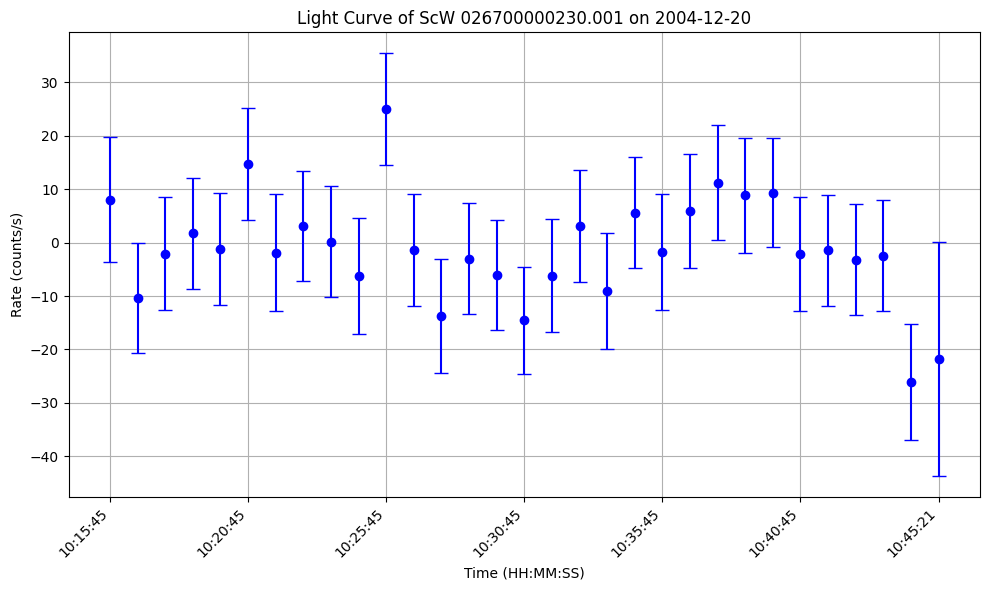

In [87]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

time = lc.data_unit[1].data['TIME']
rate = lc.data_unit[1].data['RATE']
error = lc.data_unit[1].data['ERROR'] # just the std of the rate

mjd_ref = lc.data_unit[1].header['MJDREF'] 

time = [Time(mjd_ref + t, format='mjd').isot for t in time]
date_str = time[0].split('T')[0]
time_labels = []
for t in time:
    time_str = t.split('T')[1]
    h, m, s = time_str.split(':')
    s = round(float(s))
    time_labels.append(f'{int(h):02}:{int(m):02}:{s:02}')


plt.figure(figsize=(10, 6))
plt.errorbar(time_labels, rate, yerr=error, label='Light Curve', color='blue',fmt='o', capsize=5)

plt.xlabel('Time (HH:MM:SS)')
plt.ylabel('Rate (counts/s)')
plt.title(f'Light Curve of ScW {scw_list[list_position]} on {date_str}')
plt.grid(True)

xticks = np.arange(0, len(time_labels), 5) 
plt.xticks(xticks, [time_labels[i] for i in xticks], rotation=45, ha='right')
plt.tight_layout()
plt.show()